In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
import numpy as np
from torch.utils.data import *
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler

## Explore Data

In [28]:
arrays = {}
with h5py.File('data\Generate_Data_Step_0_496_264_20020601_20190409.mat', 'r') as f:
    for k, v in f.items():
        arrays[k] = np.array(v)

In [73]:
data = h5py.File('data\Generate_Data_Step_0_496_264_20020601_20190409.mat', 'r')['samples']
# data = data[:,:256,:256]

AttributeError: 'Dataset' object has no attribute 'value'

In [69]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(data.reshape(-1,1))

In [70]:
print(scaler.data_max_, scaler.data_min_)

[31.9325] [17.0525]


In [3]:
for k, v in arrays.items():
    print(k, v)

compress_flag [[1.]]
cr [[2.]]
day_beg [[1.]]
day_end [[9.]]
fill_nan_grids_flag [[1.]]
lat_n_beg [[761.]]
lat_n_end [[1288.]]
lon_n_beg [[-160.]]
lon_n_end [[831.]]
month_beg [[6.]]
month_end [[4.]]
samples [[[24.3575 24.355  24.2325 ... 22.99   22.9525 22.9175]
  [24.6575 24.6875 24.5675 ... 23.05   23.0275 23.0775]
  [24.7175 24.7675 24.76   ... 23.0375 23.04   23.1525]
  ...
  [27.4075 27.43   27.42   ... 28.0225 28.1525 28.2625]
  [27.4575 27.4275 27.425  ... 27.4625 27.805  27.81  ]
  [27.4925 27.45   27.42   ... 27.495  27.54   27.3925]]

 [[24.5625 24.745  24.8175 ... 22.7775 22.7175 22.63  ]
  [25.1325 25.095  25.07   ... 22.7825 22.7225 22.675 ]
  [25.245  25.19   25.0375 ... 22.9575 22.9475 22.8625]
  ...
  [27.91   27.9025 27.8775 ... 27.3125 27.66   27.825 ]
  [28.13   28.115  28.03   ... 27.265  27.5825 27.6825]
  [28.32   28.185  28.09   ... 27.21   27.3875 27.3525]]

 [[24.9375 25.0275 24.9375 ... 22.77   22.775  22.7525]
  [25.02   25.05   25.27   ... 22.8075 22.8225 2

In [4]:
tem_data = arrays['samples'][:,:256,:256]
idx = arrays['y_m_d_jd_mjd_table']
temperature = np.array(tem_data)
print(temperature.shape)

(6157, 256, 256)


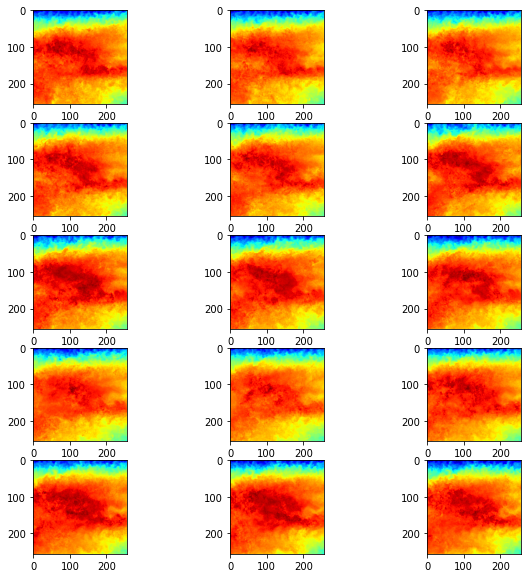

In [5]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(temperature[100:115]):
    plt.subplot(5,3, i+1)
    plt.imshow(img, cmap='jet')
    plt.savefig('temperature.png')


## Load Dataset

In [6]:
# Create a dataset
# Input: 32, Output: 128
def split_dataset(dataset, length=8+32, steps=1, split_rate=0.7):

    split_idx = round(dataset.shape[0]*split_rate)
    train_length = np.floor((split_idx-length)/steps + 1).astype(int)
    test_length = np.floor((dataset.shape[0]-split_idx-length)/steps + 1).astype(int)

    train_idx = np.zeros((train_length, length), dtype=int)
    test_idx = np.zeros((test_length, length), dtype=int)

    for i in range(train_length):
        train_idx[i] = np.arange(i*steps, i*steps+length, 1, dtype=int)

    for i in range(test_length):
        test_idx[i] = np.arange(split_idx+i*steps, split_idx+i*steps+length, 1, dtype=int)

    return train_idx, test_idx

In [7]:
in_channels = 8
out_channels = 32
len = in_channels + out_channels
train_idx, test_idx = split_dataset(temperature, length=len, steps=1, split_rate=0.7)

In [8]:
train_x_idx = train_idx[:, :in_channels]
train_y_idx = train_idx[:, in_channels:]
test_x_idx = test_idx[:, :in_channels]
test_y_idx = test_idx[:, in_channels:]

In [9]:
import h5py
f = h5py.File("data/dataset-idx-8-32-1.h5", "w")
f.create_dataset("train_x_idx", data=train_x_idx)
f.create_dataset("train_y_idx", data=train_y_idx)
f.create_dataset("test_x_idx", data=test_x_idx)
f.create_dataset("test_y_idx", data=test_y_idx)
f.close()

In [93]:
class MyDataset(Dataset):
    def __init__(self, root, mode, in_channels=8, out_channels=32, steps=1, transform=None):
        super(MyDataset, self).__init__()
        self.root = root
        self.dataset = h5py.File(self.root, 'r')['samples'][:]
        self.steps = steps
        self.channel_length = in_channels + out_channels
        self.transform = transform
        self.split_idx = int(self.dataset.shape[0]*0.7)
        
        # Get max and min data for data rescaling
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler = scaler.fit(self.dataset.reshape(-1,1))
        self.data_max_, self.data_min_ = scaler.data_max_, scaler.data_min_

        # Generate index of the dataset 
        if mode == "train":
            self.length = np.floor((self.split_idx-self.channel_length)/steps + 1).astype(int)
            self.data_idx = np.zeros((self.length, self.channel_length), dtype=int)

            for i in range(self.length):
                self.data_idx[i] = np.arange(i*steps, i*steps+self.channel_length, 1, dtype=int)

            self.x_idx = self.data_idx[:, :in_channels]
            self.y_idx = self.data_idx[:, in_channels:]
        else:
            self.length = np.floor((self.dataset.shape[0]-self.split_idx-self.channel_length)/steps + 1).astype(int)
            self.data_idx = np.zeros((self.length, self.channel_length), dtype=int)

            for i in range(self.length):
                self.data_idx[i] = np.arange(self.split_idx+i*steps, self.split_idx+i*steps+self.channel_length, 1, dtype=int)

            self.x_idx = self.data_idx[:, :in_channels]
            self.y_idx = self.data_idx[:, in_channels:]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Use size of 256*256
        x = self.dataset[self.x_idx[idx]][:,:256,:256]
        y = self.dataset[self.y_idx[idx]][:,:256,:256]
        x = self.rescale(x)
        y = self.rescale(y)
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

    def rescale(self, x):
        # scale to (0,1)
        x = (x - self.data_min_)/(self.data_max_ - self.data_min_)
        return x


In [94]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [95]:
root = 'data\Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=8, out_channels=32, steps=1)
test_dataset = MyDataset(root, mode='test', in_channels=8, out_channels=32, steps=1)

In [ ]:
sample = train_dataset[0][0]
print(sample)

None


In [ ]:
plt.imshow(sample[0], cmap='jet')

TypeError: 'NoneType' object is not subscriptable